# STA 141B Final Project
Fall 2018

Xavier Hung

Weiyi Chen

## Problem: Is there a correlation between speeding and red light camera violations?
### Case study: Chicago

Many people are likely to speed up as they approach an intersection when the traffic light turns yellow.  It is dangerous and can sometimes lead to a fatal crash.  The red light camera is intended to increase public safety by preventing people from running a red light, but is it really effective?

This common occurrence brought us to analyze the association between red light violations and speeding. 

####  Data Extraction

We obtained our data from the City of Chicago. There are four CSV files: red light camera locations, red light camera violations, speed camera locations, and speed camera violations (details of these data can be found at https://data.cityofchicago.org/browse?q=red+light+camera&sortBy=relevance).

In [1]:
import os
import pandas as pd
import numpy as np
import math
from ast import literal_eval
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import Title
from bokeh.tile_providers import CARTODBPOSITRON
import numpy
from scipy.stats import linregress
from scipy.stats import spearmanr
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

redlight_loc = pd.read_csv('red-light-camera-locations.csv')
redlight_violations = pd.read_csv('red-light-camera-violations.csv')

speed_loc = pd.read_csv('speed-camera-locations.csv')
speed_violations = pd.read_csv('speed-camera-violations.csv')

`speed_loc` and `redlight_loc` have columns, latitude and longitude. We use Mercator projection to convert latitude and longitude into coordinates, and plot the locations of red light cameras and speed cameras.

In [2]:
# plot red light cameras and speed cameras locations
speed_loc["COORDINATES"] = '('+ speed_loc["LATITUDE"].astype(str) +','+ speed_loc["LONGITUDE"].astype(str) + ')'
redlight_loc["COORDINATES"] = '('+ redlight_loc["LATITUDE"].astype(str) +','+ redlight_loc["LONGITUDE"].astype(str) + ')'

def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

speed_loc['coords_x'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc['coords_y'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc['coords_x'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc['coords_y'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9790000, -9735000), y_range=(5105000, 5165000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc['coords_x'], y = redlight_loc['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc['coords_x'], y = speed_loc['coords_y'], legend = "Speed Camera")

t = Title()
t.text = 'Locations of All Speed Cameras and Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In Chicago, 0.0001 latitude is about 111.2 meters when longitude is constant. When latitude is constant, 0.001 longitude is about 82.69 meters. 
link: https://www.movable-type.co.uk/scripts/latlong.html

We subset the data by red light cameras and speed cameras that are near each other by 0.001 latitude and longitude. 

In [3]:
# redlight_loc_copy is a subset of redlight_loc and contains the locations of red light cameras near speed cameras
# speed_loc_copy is a subset of speed_loc and contains the locations of speed cameras near red light cameras
redlight_loc_copy = pd.DataFrame(columns = redlight_loc.columns.values)
speed_loc_copy = pd.DataFrame(columns = speed_loc.columns.values)
pairs = pd.DataFrame(columns = ['speed', 'redlight'])

# find red light cameras near speed cameras
for i in range(0,speed_loc.shape[0]):
    for j in range(0,redlight_loc.shape[0]):
        if abs(speed_loc.iloc[i,4] - redlight_loc.iloc[j,5]) < 0.001 and abs(speed_loc.iloc[i,5] - redlight_loc.iloc[j,6]) < 0.001:
            #if pd.to_datetime(speed_loc['GO-LIVE DATE']).dt.year[i] < pd.to_datetime(redlight_loc['GO LIVE DATE']).dt.year[j]:
            redlight_loc_copy = redlight_loc_copy.append(redlight_loc.iloc[j], ignore_index = True)
            speed_loc_copy = speed_loc_copy.append(speed_loc.iloc[i], ignore_index = True)
            temp = pd.DataFrame({'speed': [speed_loc.iloc[i,0]], 'redlight': [redlight_loc.iloc[j,0]]})
            pairs = pairs.append(temp)
pairs = pairs.reset_index(drop = True)

In [4]:
# plot red light cameras near speed cameras
redlight_loc_copy["COORDINATES"] = '('+ redlight_loc_copy["LATITUDE"].astype(str) +','+ redlight_loc_copy["LONGITUDE"].astype(str) + ')'
speed_loc_copy["COORDINATES"] = '('+ speed_loc_copy["LATITUDE"].astype(str) +','+ speed_loc_copy["LONGITUDE"].astype(str) + ')'

speed_loc_copy['coords_x'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc_copy['coords_y'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc_copy['coords_x'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc_copy['coords_y'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9780000, -9745000), y_range=(5120000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc_copy['coords_x'], y = redlight_loc_copy['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc_copy['coords_x'], y = speed_loc_copy['coords_y'], legend = "Speed Camera",)

t = Title()
t.text = 'Speed Cameras in Close Proximity to Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In [7]:
# change format of addresses in speed_loc_copy to match format of addresses in speed_violations
remove = ["(Speed", "Camera)", "Ave", "ST", "Rd", "St", "Blvd"]
for i in range(0, speed_loc_copy.shape[0]):
    speed_loc_copy.iloc[i,0] = " ".join([word for word in speed_loc_copy.iloc[i,0].split() if word not in remove])

for i in range(0, pairs.shape[0]):
    pairs.iloc[i,0] = " ".join([word for word in pairs.iloc[i,0].split() if word not in remove]).upper()
    pairs.iloc[i,1] = pairs.iloc[i,1].upper()

speed_violations_copy = pd.DataFrame(columns = speed_violations.columns.values)    
    
# subset speed violations where speed cameras are near red light cameras
for i in range(0, speed_loc_copy.shape[0]):
    address = speed_violations[speed_violations['ADDRESS'].str.contains(speed_loc_copy.iloc[i,0].upper())]
    speed_violations_copy = speed_violations_copy.append(address, ignore_index = True)
    if len(address.index) > 0:
        pairs.iloc[i,0] = address.iloc[0,0]

In [8]:
redlight_violations_copy = pd.DataFrame(columns = redlight_violations.columns.values)

# subset red light violations where speed cameras are near red light cameras
# this will take a while
for i in range (0, redlight_violations.shape[0]):
    for j in range(0, redlight_loc_copy.shape[0]):
        intersection1 = redlight_violations.iloc[i,0].replace(' AND ', '/').replace(' and ', '/').split('/')
        intersection2 = redlight_loc_copy.iloc[j,0].split('-')
        if len(intersection1) > 1 and len(intersection2) > 1:
            if intersection1[0] == intersection2[0].upper() or intersection1[0] == intersection2[1].upper():
                if intersection1[1] == intersection2[0].upper() or intersection1[1] == intersection2[1].upper():
                    redlight_violations_copy = redlight_violations_copy.append(redlight_violations.iloc[i], ignore_index = True)
                    pairs.iloc[j,1] = redlight_violations.iloc[i,0]

The Spearman correlation coefficient and p-value for speed violations at 449 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.162963453255 and 2.78044192069e-52, respectively.
The Spearman correlation coefficient and p-value for speed violations at 450 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.264360762275 and 2.79546990715e-134, respectively.
The Spearman correlation coefficient and p-value for speed violations at 324 E ILLINOIS ST and red light violations at COLUMBUS AND ILLINOIS are -0.0754133215296 and 0.00111370502749, respectively.


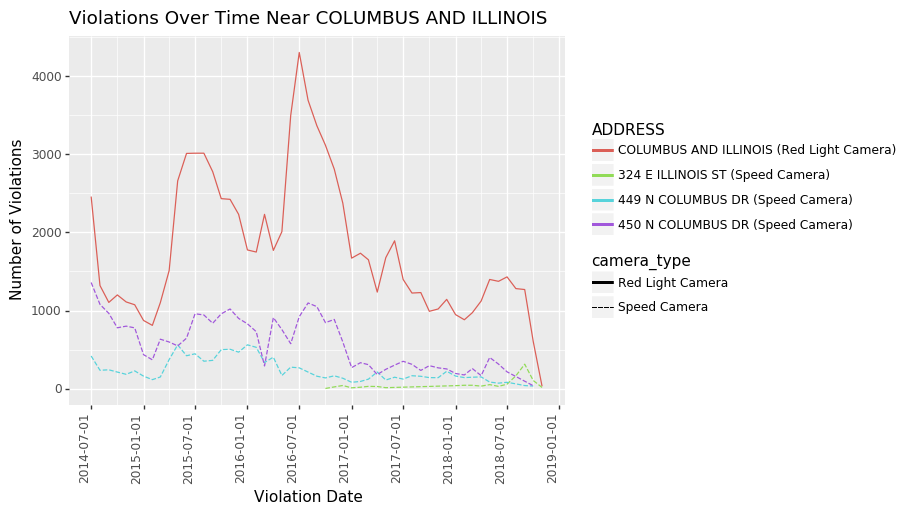

<ggplot: (-9223372036557937250)>
The Spearman correlation coefficient and p-value for speed violations at 5030 S PULASKI and red light violations at PULASKI AND ARCHER are 0.0858098835074 and 8.32305340821e-06, respectively.
The Spearman correlation coefficient and p-value for speed violations at 4929 S PULASKI and red light violations at PULASKI AND ARCHER are 0.0805567849214 and 3.18889544956e-05, respectively.


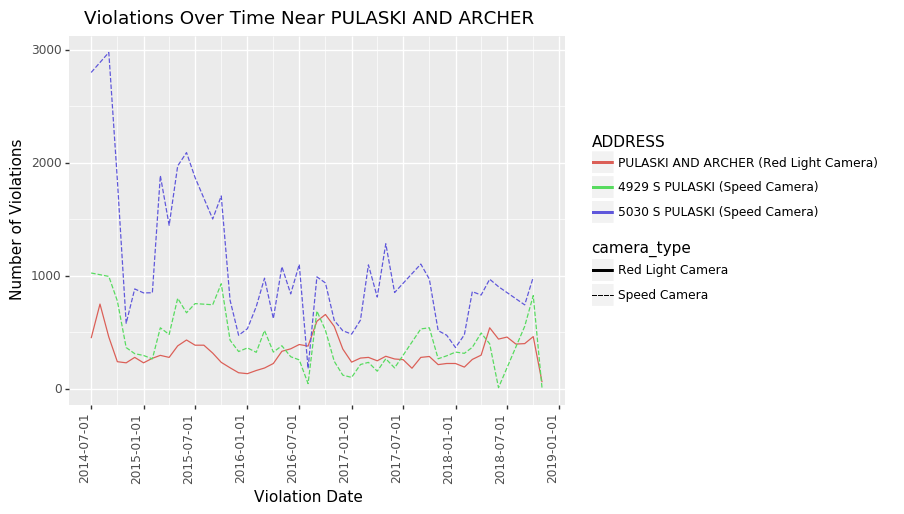

<ggplot: (-9223372036541700804)>
The Spearman correlation coefficient and p-value for speed violations at 7833 S PULASKI and red light violations at PULASKI AND 79TH are 0.0421715594408 and 0.0309514706502, respectively.
The Spearman correlation coefficient and p-value for speed violations at 7826 S PULASKI and red light violations at PULASKI AND 79TH are 0.0141353546134 and 0.468865265261, respectively.


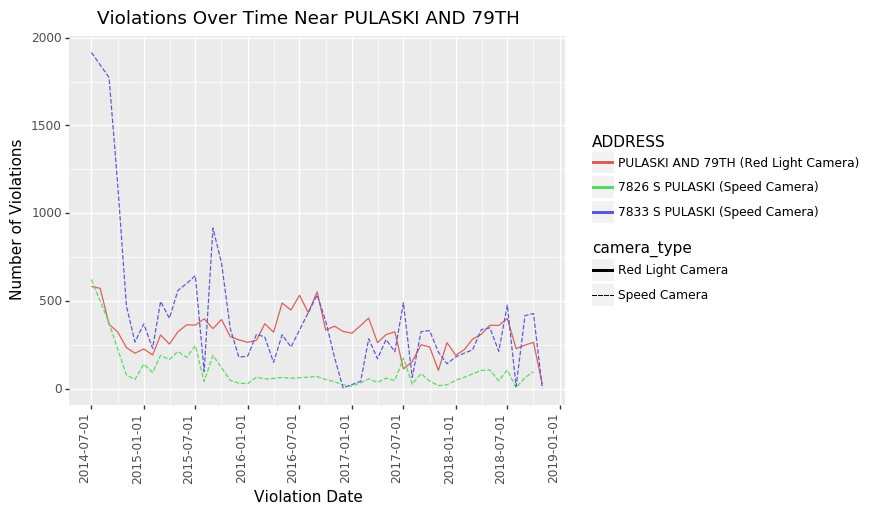

<ggplot: (296454415)>
The Spearman correlation coefficient and p-value for speed violations at 5532 S KEDZIE AVE and red light violations at 55TH AND KEDZIE are 0.0196416695613 and 0.30387986204, respectively.
The Spearman correlation coefficient and p-value for speed violations at 3212 W 55TH ST and red light violations at 55TH AND KEDZIE are -0.0428981540587 and 0.065662139916, respectively.
The Spearman correlation coefficient and p-value for speed violations at 3217 W 55TH ST and red light violations at 55TH AND KEDZIE are 0.0192534438388 and 0.450386639939, respectively.


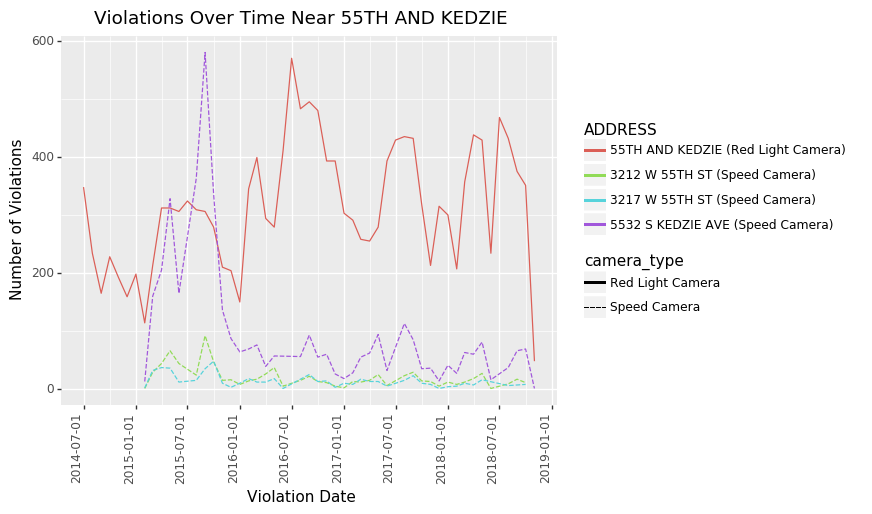

<ggplot: (296718095)>
The Spearman correlation coefficient and p-value for speed violations at 819 E 71ST ST and red light violations at COTTAGE GROVE AND 71ST are -0.298144378532 and 0.0121817373417, respectively.
The Spearman correlation coefficient and p-value for speed violations at 7122 S SOUTH CHICAGO AVE and red light violations at COTTAGE GROVE AND 71ST are -0.0650908855775 and 0.597942453407, respectively.


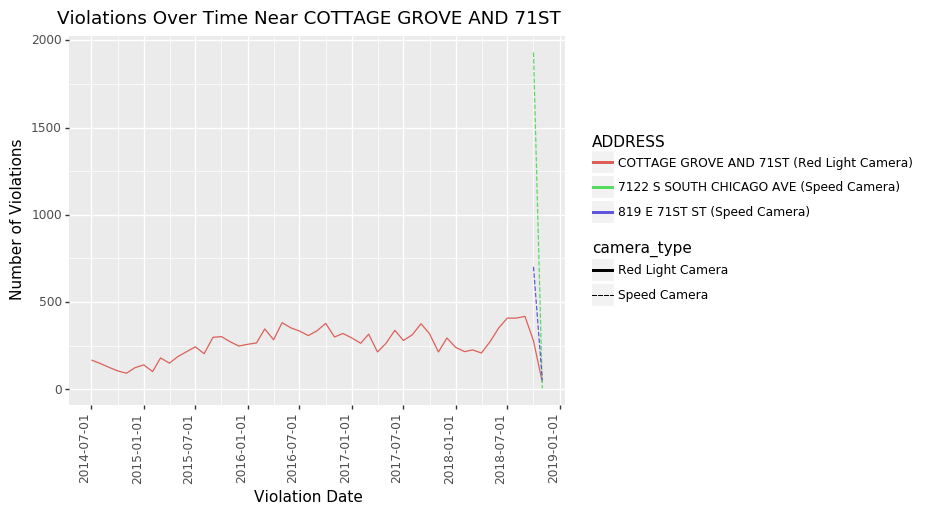

<ggplot: (-9223372036558081392)>
The Spearman correlation coefficient and p-value for speed violations at 5433 S PULASKI and red light violations at 55TH and PULASKI are 0.0513666664902 and 0.0130290766203, respectively.
The Spearman correlation coefficient and p-value for speed violations at 5428 S PULASKI and red light violations at 55TH and PULASKI are 0.126406090074 and 1.19662717129e-09, respectively.


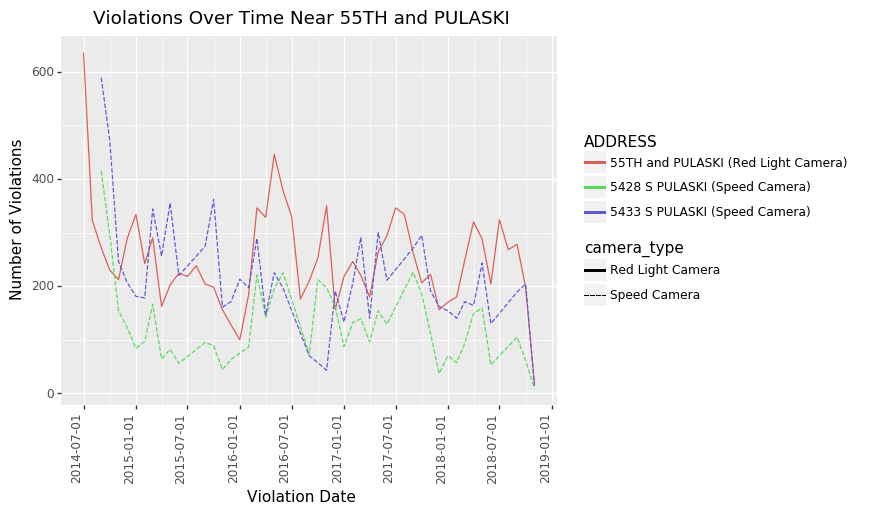

<ggplot: (-9223372036557143587)>
The Spearman correlation coefficient and p-value for speed violations at 3534 N WESTERN and red light violations at WESTERN AND ADDISON are 0.0829683054404 and 0.0101969649149, respectively.


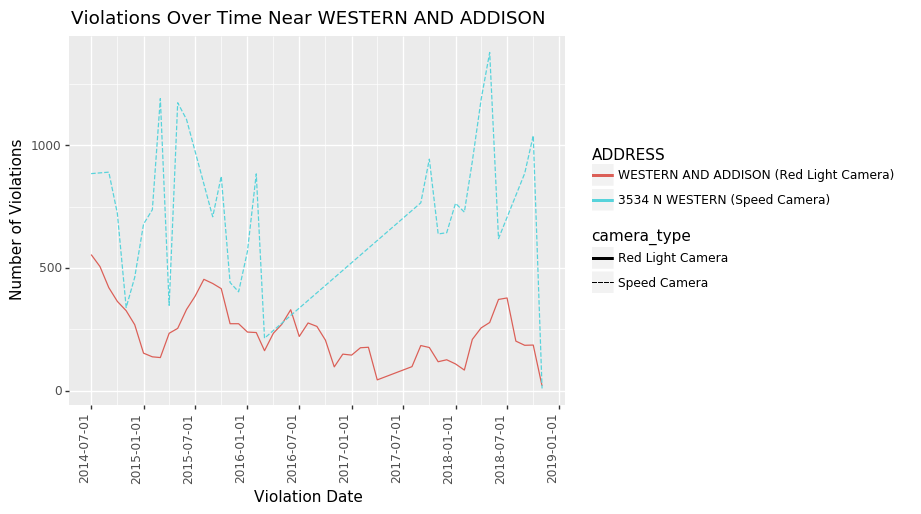

<ggplot: (296568475)>
The Spearman correlation coefficient and p-value for speed violations at 2335 W CERMAK RD and red light violations at WESTERN AND CERMAK are 0.0126478366504 and 0.693407633301, respectively.


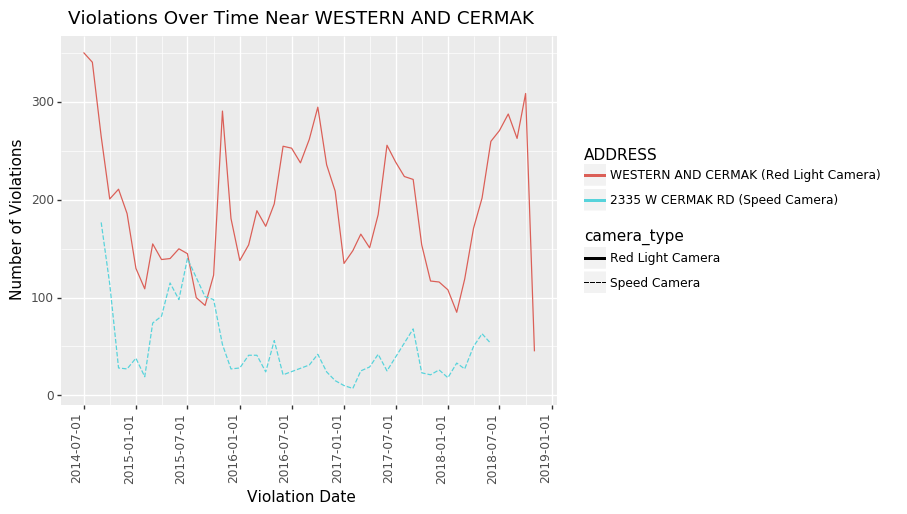

<ggplot: (294987605)>
The Spearman correlation coefficient and p-value for speed violations at 732 N PULASKI RD and red light violations at PULASKI AND CHICAGO are -0.0305480932393 and 0.274597466049, respectively.


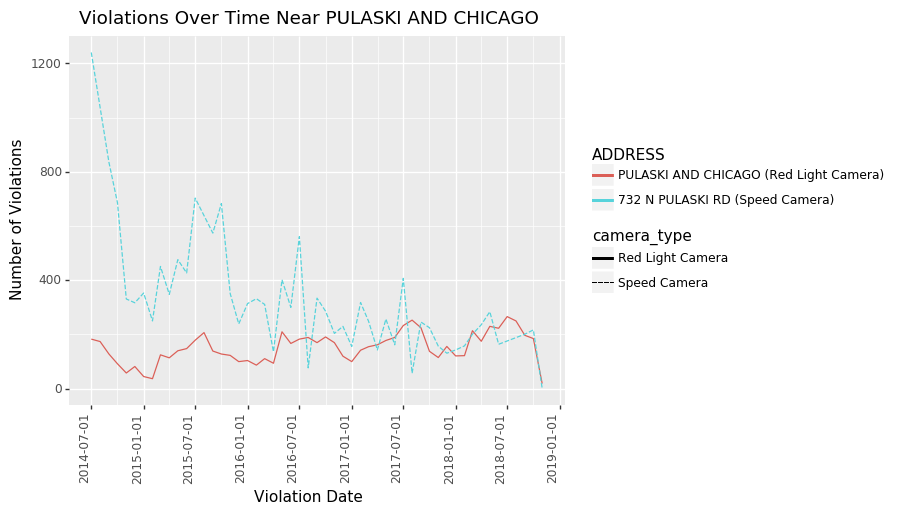

<ggplot: (297608989)>
The Spearman correlation coefficient and p-value for speed violations at 4123 N CENTRAL AVE and red light violations at CENTRAL AND IRVING PARK are -0.0261146025436 and 0.198785140848, respectively.


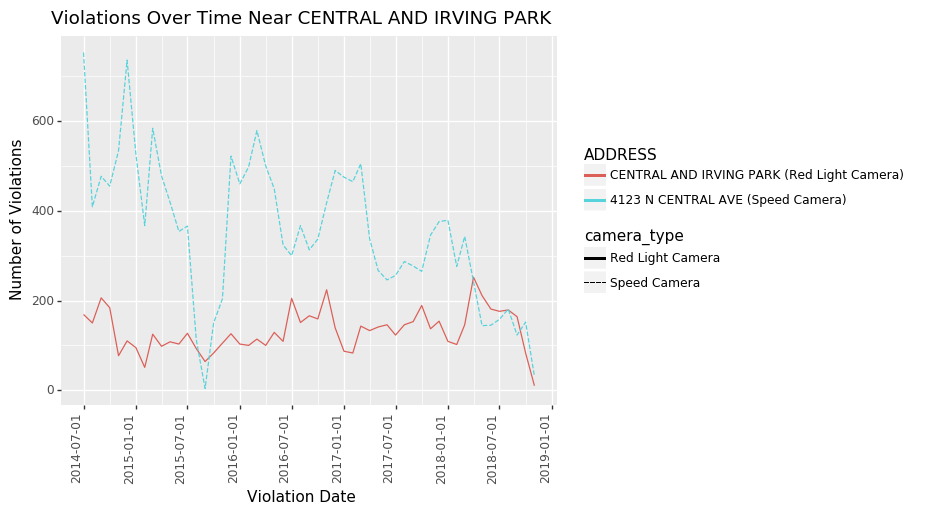

<ggplot: (-9223372036557175566)>


In [17]:
redlight = redlight_violations_copy.groupby('INTERSECTION')['VIOLATIONS'].sum().sort_values(ascending = False)

# output in order of most red light violations to least red light violations
for i in range(0, len(redlight)):
    rlc_violation_intersection = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][i])].reset_index(drop = True)

    rlc_speed = pd.DataFrame()
    temp = pairs.loc[pairs['redlight'] == rlc_violation_intersection.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
    for j in range(0, len(temp)):
        rlc_speed = rlc_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[j])].reset_index(drop = True))

    temp1 = rlc_speed
    temp1['VIOLATION DATE'] = pd.to_datetime(temp1['VIOLATION DATE'])
    temp2 = rlc_violation_intersection
    temp2['VIOLATION DATE'] = pd.to_datetime(temp2['VIOLATION DATE'])
    
    for k in range(0, len(temp1['ADDRESS'].value_counts())):
        temp = temp1.loc[temp1['ADDRESS'] == temp1['ADDRESS'].value_counts().index[k]]
        x1 = pd.DataFrame()
        x2 = pd.DataFrame()
        for l in range(0, len(temp)):
            for m in range(0, len(temp2)):
                if(temp['VIOLATION DATE'][l] == temp2['VIOLATION DATE'][m]):
                    x1 = x1.append(temp.iloc[l])
                    x2 = x2.append(temp2.iloc[m])
        #print('The Pearson correlation coefficient for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', numpy.corrcoef(x1['VIOLATIONS'], x2['VIOLATIONS'])[0,1], '.', sep = '')
        print('The Spearman correlation coefficient and p-value for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' are ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[0], ' and ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[1], ', respectively.', sep = '')
        #print('R-squared for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', linregress(x1['VIOLATIONS'], x2['VIOLATIONS'])[2] ** 2, '.', sep = '')
    
    rlc_speed['date'] = pd.to_datetime(rlc_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_speed['date'] = pd.to_datetime(rlc_speed['date'])
    temp = rlc_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
    plotdata_speed = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})
    plotdata_speed['camera_type'] = 'Speed Camera'

    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['date'])
    temp = rlc_violation_intersection.groupby('date')['VIOLATIONS'].sum()
    plotdata_redlight = pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': rlc_violation_intersection.iloc[0,0]})
    plotdata_redlight['camera_type'] = 'Red Light Camera'

    plotdata_speed = plotdata_speed.loc[plotdata_speed['count'] != 0]
    plotdata_redlight = plotdata_redlight.loc[plotdata_redlight['count'] != 0]

    plotdata_speed['ADDRESS'] += ' (Speed Camera)'
    plotdata_redlight['ADDRESS'] += ' (Red Light Camera)'

    print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS', linetype = 'camera_type'), data = plotdata_redlight)
      + geom_line()
      + geom_line(aes(x = 'date', y = 'count', color = 'ADDRESS', linetype = 'camera_type'), data = plotdata_speed)
      + labs(x = 'Violation Date', y = 'Number of Violations')
      + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
      + ggtitle('Violations Over Time Near ' + rlc_violation_intersection.iloc[0,0]))